In [1]:
import uproot as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from global_settings import * 
from df_utils import * 
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [2]:
run = "run1"
dm_type = "fermion"
mass = "0.05"
ratio = "0.6"
data = True
create_hists=False
target_pot = 1.
signal_pot = {}
extra_scaling = 2.

#Scaled to the observed upper limit 
signal_limit_scaling = (0.000000115393037788935/(0.001)**2)**2


if(not data):
    extra_scaling = 0.4
    signal_limit_scaling = (0.000000115393037788935/(0.001)**2)**2

signal_correction = { "0.01":0.94903385, "0.02":1.03561568, "0.03":1.02326517, "0.04":1.00641579, 
                     "0.05":1.00650082, "0.06":1.01293082, "0.07":1.07433777, 
                     "0.08":1.10175345, "0.09":1.0415591 , "0.10":1.1014797}

if(dm_type == "fermion"):
    signal_pot = { "0.01":1.06e20, "0.02":9.44e+20, "0.03":4.02e+21, 
                  "0.04":1.5e+22, "0.05":5.03e+22, "0.06":1.57e+23,
                  "0.07":4.6e+23, "0.08":1.37e+24, 
                  "0.09":2.77e+24, "0.10":6.62e+24}

else: 
    signal_pot = { "0.01":8.8e+20, "0.02": 9.05e+21, "0.03":4.7e+22, 
                  "0.04":1.8e+23, "0.05":7.7e+23, "0.06":2.7e+24,
                  "0.07":7.9e+24, "0.08":2.34e+25, 
                  "0.09":3.9e+25, "0.10":8.8e+25}


scalings = {}

if(run == "run1"):
    run_flag = "Run 1"
    target_pot = 2.2e+20
    scalings = scalings_run1
    pot_label = r'      $2.2\times10^{20}$ POT'
    my_custom_bins = [ 0., 1.375, 2.75, 4.125, 5.5, 11.] # Last four bins merged bc of low stats
    final_custom_bins = [ 0., 1.375, 2.75, 4.125, 5.5, 6.875] # One final overflow bin 
    meson_correction_pi0 = meson_scalings["pi0"]
    meson_correction_eta = meson_scalings["eta"]
else:
    run_flag = "Run 3"
    target_pot = 5.0e20
    scalings = scalings_run3
    pot_label = r'      $5.0\times10^{20}$ POT'
    my_custom_bins = [ 0., 1.375, 2.75, 4.125,5.5,11.] # Last four bins merged bc of low stats
    final_custom_bins = [ 0., 1.375, 2.75, 4.125, 5.5, 6.875] # One final overflow bin
    meson_correction_pi0 = meson_scalings["pi0"]
    meson_correction_eta = meson_scalings["eta"]



In [3]:
base_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/" + run + "_samples/" 
signal_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/" + run + "_signal/"
plots_dir = "/home/lmlepin/Desktop/Plots_DT_Drive/2023/data_mc/"

df_nu = pd.read_csv(base_dir + run + "_nu_overlay_CNN_scores_8441_steps.csv")
df_dirt = pd.read_csv(base_dir + run + "_dirt_CNN_scores_8441_steps.csv")
df_offbeam = pd.read_csv(base_dir + run + "_offbeam_CNN_scores_8441_steps.csv")
df_beamon = pd.read_csv(base_dir + run + "_beamon_CNN_scores_8441_steps.csv")

# good run fix 

good_run_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/good_runs/"
good_run_df = pd.read_csv(good_run_dir + "goodruns_" + run + ".txt")
good_run_list = good_run_df['good_run'].to_numpy()

print("Number of entries before good run filter: ", len(df_beamon))

df_beamon = df_beamon[df_beamon['run_number'].isin(good_run_list)]

print("Number of entries after good run filter: ", len(df_beamon))
###########################


df_nu = df_nu.drop_duplicates()
df_dirt = df_dirt.drop_duplicates()
df_offbeam = df_offbeam.drop_duplicates()
df_beamon = df_beamon.drop_duplicates()

nu_fraction = len(df_nu)/len(df_nu[df_nu['signal_score']>= 0.])
dirt_fraction = len(df_dirt)/len(df_dirt[df_dirt['signal_score'] >= 0.])
beamoff_fraction = len(df_offbeam)/len(df_offbeam[df_offbeam['signal_score'] >= 0.])
beamon_fraction = len(df_beamon)/len(df_beamon[df_beamon['signal_score'] >= 0.])


print("Nu fraction: ", nu_fraction)
print("Dirt fraction: ", dirt_fraction)
print("beam-off fraction: ", beamoff_fraction)
print("beamon-on fraction: ", beamon_fraction)

# Note that by dividing by the beamon_fraction we are taking into account the events that
# are lost due to failed jobs in larcv 

nu_scaling = target_pot*scalings["nu"]*(nu_fraction)/(beamon_fraction)
dirt_scaling = target_pot*scalings["dirt"]*(dirt_fraction)/(beamon_fraction)
offbeam_scaling = scalings["beamoff"]*(beamoff_fraction)/(beamon_fraction)


multisim_uncertainty = 0.2 
detvars_uncertainty = 0.3
dirt_uncertainty = 1.0


MC_weight_branch(df_nu)
MC_weight_branch(df_dirt)

Number of entries before good run filter:  4369
Number of entries after good run filter:  4021
Nu fraction:  1.0160505483332123
Dirt fraction:  1.0348168331819558
beam-off fraction:  1.014421838784445
beamon-on fraction:  1.0027431421446384


In [4]:
def filter_df(df):
    df = df[df['signal_score'] >= 0.5]
    return df 

def GetStatsUncert(df_a, weight_array,my_custom_bins,plot_var):
    (counts_df, bins_df) = np.histogram(df_a[plot_var], bins = my_custom_bins, weights=np.square(weight_array))
    return counts_df

In [5]:
'''

max_tresh = 11.

df_nu = df_nu[df_nu['signal_score'] >= 0.5]
df_dirt = df_dirt[df_dirt['signal_score'] >= 0.5]
df_offbeam = df_offbeam[df_offbeam['signal_score'] >= 0.5]
df_beamon = df_beamon[df_beamon['signal_score'] >= 0.5]


df_nu['signal_score'] = logit_transform(df_nu['signal_score'])
df_dirt['signal_score'] = logit_transform(df_dirt['signal_score'])
df_offbeam['signal_score'] = logit_transform(df_offbeam['signal_score'])
df_beamon['signal_score'] = logit_transform(df_beamon['signal_score'])


df_data_aux = df_beamon[df_beamon['signal_score'] > 5.5]

variable = 'signal_score'
up_plot = 6.875
down_plot = 0.


# Open signal histogram:

signal_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/{}_signal/".format(run)
signal_file = u.open(signal_dir + "{}_ratio_{}_signal_hist_{}_CNN.root".format(dm_type,ratio,run))
(counts_signal,bins_signal) = signal_file["signal_"+mass].to_numpy()


(counts_fake, bins_final) = np.histogram(df_nu[variable], bins = final_custom_bins)
(counts_nu, bins_nu) = np.histogram(df_nu[variable], bins = my_custom_bins, weights = df_nu['weight'])
(counts_dirt, bins_dirt) = np.histogram(df_dirt[variable], bins = my_custom_bins, weights = df_dirt['weight'])
(counts_offbeam, bins_offbeam) = np.histogram(df_offbeam[variable], bins = my_custom_bins)
(counts_beamon, bins_beamon) = np.histogram(df_beamon[variable], bins = my_custom_bins)

total_bkg_exp = np.sum(counts_nu)*nu_scaling + np.sum(counts_dirt)*dirt_scaling + np.sum(counts_offbeam)*offbeam_scaling
data_mc = np.sum(counts_beamon)/total_bkg_exp

print("Showing results for: " + run)
print("Number of dark tridents M_A="+str(mass)+" :" + str(np.sum(counts_signal)))
print("Number of neutrinos: " + str(np.sum(counts_nu)*nu_scaling))
print("Number of dirt: " + str(np.sum(counts_dirt)*dirt_scaling))
print("Number of beam-off: " + str(np.sum(counts_offbeam)*offbeam_scaling))
print("Total background: " + str(total_bkg_exp))
print("Number of beam-on: " + str(np.sum(counts_beamon)))
print("Data/MC: " + str(data_mc))




# Set plot specs with patches!!!

if(data):
    dt_legend = r'Dark trident ({:.2f}) $\times$ {}'.format(np.sum(counts_signal)*signal_limit_scaling,extra_scaling)

else:
    dt_legend = r'Dark trident ({:.2f}) $\times$ {}'.format(np.sum(counts_signal)*signal_limit_scaling,extra_scaling)
nu_legend = r'In cryo $\nu$ ({:.2f})'.format(np.sum(counts_nu)*nu_scaling)
dirt_legend = r'Out of cryo $\nu$ ({:.2f})'.format(np.sum(counts_dirt)*dirt_scaling)
beamoff_legend = r'Beam-off ({:.2f})'.format(np.sum(counts_offbeam)*offbeam_scaling)
beamon_legend = r'NuMI data ({:.2f})'.format(np.sum(counts_beamon))

stacked_colors = ["darkviolet","navy","deepskyblue"]
stacked_legend = [nu_legend, dirt_legend, beamoff_legend]
stacked_bins = [bins_final[:-1], bins_final[:-1], bins_final[:-1]]
stacked_list = [counts_nu*nu_scaling, counts_dirt*dirt_scaling, counts_offbeam*offbeam_scaling ]

stacked_signal_hist = counts_signal*signal_limit_scaling*extra_scaling + counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling


# Getting stats error, note: GetStatsUncert gives you the sum of the weights squared on each bin 
counts_bkg = counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling
stats_nu = GetStatsUncert(df_nu, df_nu['weight']*nu_scaling,final_custom_bins,variable)
stats_dirt = GetStatsUncert(df_dirt, df_dirt['weight']*dirt_scaling,final_custom_bins,variable)
stats_beamoff = GetStatsUncert(df_offbeam, np.ones(len(df_offbeam))*offbeam_scaling,final_custom_bins,variable)
stats_total = np.sqrt(stats_nu + stats_dirt + stats_beamoff)


print("\n")
print("Showing statistical uncertainty arrays...")
print("Nu overlay: ", np.sqrt(stats_nu))
print("Dirt: ", np.sqrt(stats_dirt))
print("Beamoff: ", np.sqrt(stats_beamoff))
print("Total : ", stats_total)


# Nu uncertainties 
nu_CV = (counts_nu*nu_scaling)
dirt_CV = (counts_dirt*dirt_scaling)
sigma_detvar = nu_CV*detvars_uncertainty
sigma_multisim = nu_CV*multisim_uncertainty
sigma_mc_dirt = dirt_CV*dirt_uncertainty

# Background uncerts
sigma_nu = np.sqrt(stats_nu + sigma_detvar**2 + sigma_multisim**2)
sigma_dirt = np.sqrt(stats_dirt + sigma_mc_dirt**2)
sigma_beamoff = np.sqrt(stats_beamoff)


# Total error 
total_error_mc = np.sqrt(sigma_nu**2 + sigma_dirt**2 + sigma_beamoff**2)
stats_error = (stats_total)/(counts_bkg)
stats_up = counts_bkg + total_error_mc
stats_down = counts_bkg - total_error_mc


print("\n")
print("Showing fractional statistical errors...")
print("Nu overlay fraction: ", np.sqrt(stats_nu)/(counts_nu*nu_scaling))
print("Dirt fraction: ", np.sqrt(stats_dirt)/(counts_dirt*dirt_scaling))
print("Beamoff fraction: ", np.sqrt(stats_beamoff)/counts_offbeam*offbeam_scaling)
print("Total fraction: ", stats_error)


# Trick for right error band on histograms 
bins_err = np.copy(bins_final)
bins_err = np.append(bins_err,[bins_err[-1] + (bins_err[2] - bins_err[1])])
stats_up = np.append(stats_up,[stats_up[-1],stats_up[-1] ])
stats_down = np.append(stats_down,[stats_down[-1],stats_up[-1]])


fig, ax = plt.subplots(2,1,figsize=large_histo_size,dpi=300,gridspec_kw={'height_ratios': [4, 1], 'hspace': 0.08})

for axis in ['top', 'bottom', 'left', 'right']:
    ax[0].spines[axis].set_linewidth(2.5)  # change width
    ax[0].spines[axis].set_color('black')    # change color
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax[1].spines[axis].set_linewidth(2.5)  # change width
    ax[1].spines[axis].set_color('black')    # change color


ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
    
ax[0].set_title(r'MicroBooNE Simulation' + ' ' + run_flag,fontsize=45,pad=15)   

if(data):
    ax[0].plot([], [], ' ', label=f"Data/MC = {data_mc:.2f}")
    ax[0].hist(bins_final[:-1], bins = bins_final, weights = stacked_signal_hist,
           histtype='step',stacked=True, color = "red", label = dt_legend,lw=4)

ax[0].hist(stacked_bins, bins = bins_final, weights = stacked_list, histtype='stepfilled',stacked=True, color = stacked_colors, 
           edgecolor="darkred", label = stacked_legend)
ax[0].fill_between(bins_err, stats_up, stats_down,color='gray',alpha=0.2,step='post')

if(data):
    ax[0].set_title(r'MicroBooNE NuMI Data' + ' ' + run_flag + ""+ pot_label ,fontsize=45,pad=15)
    ax[0].errorbar(bins_final[:-1]+ 0.5*(bins_final[1:] - bins_final[:-1]),counts_beamon,yerr=np.sqrt(counts_beamon),fmt='o',markersize=12, capsize=15, color='black',label=beamon_legend)

if(not data):  
    ax[0].hist(bins_final[:-1], bins = bins_final,weights=counts_signal*signal_limit_scaling*extra_scaling, histtype='step',label=dt_legend ,fill=False, edgecolor='red', linewidth=4)
ax[0].legend(fontsize=45)
ax[0].tick_params(axis="y", which='major', direction="in",length=20,width=2.5,pad=15, labelsize=45)
ax[0].tick_params(axis="y", which='minor', direction="in",length=10,width=1.0,labelleft=False, labelsize=45)
ax[0].tick_params(axis="x", which='major', direction="in",length=20,width=2.5,pad=15, bottom=True,top=False,labelbottom=False)
ax[0].tick_params(axis="x", which='minor', direction="in",length=10,width=2.0, bottom=True,top=False,labelbottom=False)
ax[0].set_xlim(down_plot,up_plot)
ax[0].set_ylabel("Events",fontsize=45, labelpad=15) 

total_pred = (counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling )
ratio = (counts_beamon - total_pred)/(total_pred)

subs_error = np.sqrt( counts_beamon + stats_total**2)

total_error = np.abs(ratio)*np.sqrt( (subs_error/(counts_beamon - total_pred))**2 + (stats_total/total_pred)**2)


if(data):
    ax[1].errorbar(bins_final[:-1]+ 0.5*(bins_final[1:] - bins_final[:-1]),ratio,yerr=total_error,fmt='o',markersize=12,capsize=15,color='black')
ax[1].hist(bins_final[:-1], bins = bins_final,weights=total_error_mc/counts_bkg,histtype='stepfilled',color='gray',alpha=0.3,lw=2)
ax[1].hist(bins_final[:-1], bins = bins_final,weights=-1*total_error_mc/counts_bkg,histtype='stepfilled',color='gray',alpha=0.3,lw=2)
ax[1].hlines(0.,down_plot,up_plot,color='black',linewidth=0.8)
#ax[1].hlines(-0.75,down_plot,up_plot,color='black',linestyle="--",linewidth=0.8)
#ax[1].hlines(0.75,down_plot,up_plot,color='black',linestyle="--",linewidth=0.8)
ax[1].hlines(-0.5,down_plot,up_plot,color='black',linestyle="--",linewidth=1.5)
ax[1].hlines(0.5,down_plot,up_plot,color='black',linestyle="--",linewidth=1.5)
ax[1].tick_params(axis='x', which='minor',direction="in", length=15, width=2.5, labelsize=45)
ax[1].tick_params(axis='y', which='minor',direction="in", length=10, width=2.5, labelsize=45)
ax[1].tick_params(axis='x', which='major',direction="in", length=20, width=2.5, pad=15, labelsize=45)
ax[1].tick_params(axis='y', which='major',direction="in", length=20, width=2.5, pad=15, labelsize=45)
ax[1].set_yticks([-0.5,0.5])
ax[1].set_ylim(-1.,1.)
ax[1].set_xlabel(r'CNN signal score',fontsize=45,labelpad=15)
ax[1].set_xlim(down_plot,up_plot)
ax[1].set_ylabel(r'Fraction error',fontsize=40,labelpad=15)
ax[0].set_xticks(np.round(bins_final,1))
ax[1].set_xticks(np.round(bins_final,1))
ax[1].set_xticklabels(["0.0", "1.4", "2.8", "4.1", "5.5", "6.9+"])
ax[1].set_xticklabels(["0.0", "1.4", "2.8", "4.1", "5.5", "6.9+"])

if(data):
    ax[1].set_ylabel(r'(D - P)/P',fontsize=40,labelpad=15)
    plt.savefig(plots_dir + "data_mc_comparison_" + run + "_" + variable + "_.pdf",bbox_inches="tight")
    plt.savefig(plots_dir + "data_mc_comparison_" + run + "_" + variable + "_.png",bbox_inches="tight")
else:
    plt.savefig(plots_dir + "CNN_distributions_" + run + "_" + variable + "_.pdf",bbox_inches="tight")
    plt.savefig(plots_dir + "CNN_distributions_" + run + "_" + variable + "_.png",bbox_inches="tight")
plt.show()

'''

'\n\nmax_tresh = 11.\n\ndf_nu = df_nu[df_nu[\'signal_score\'] >= 0.5]\ndf_dirt = df_dirt[df_dirt[\'signal_score\'] >= 0.5]\ndf_offbeam = df_offbeam[df_offbeam[\'signal_score\'] >= 0.5]\ndf_beamon = df_beamon[df_beamon[\'signal_score\'] >= 0.5]\n\n\ndf_nu[\'signal_score\'] = logit_transform(df_nu[\'signal_score\'])\ndf_dirt[\'signal_score\'] = logit_transform(df_dirt[\'signal_score\'])\ndf_offbeam[\'signal_score\'] = logit_transform(df_offbeam[\'signal_score\'])\ndf_beamon[\'signal_score\'] = logit_transform(df_beamon[\'signal_score\'])\n\n\ndf_data_aux = df_beamon[df_beamon[\'signal_score\'] > 5.5]\n\nvariable = \'signal_score\'\nup_plot = 6.875\ndown_plot = 0.\n\n\n# Open signal histogram:\n\nsignal_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/{}_signal/".format(run)\nsignal_file = u.open(signal_dir + "{}_ratio_{}_signal_hist_{}_CNN.root".format(dm_type,ratio,run))\n(counts_signal,bins_signal) = signal_file["signal_"+mass].to_numpy()\n\n\n(counts_fake, bins_final) = np.

Showing results for: run1
Number of dark tridents M_A=0.05 :719.7990893007694
Number of neutrinos: 67.06694057137072
Number of dirt: 8.65096310170542
Number of beam-off: 95.95407199866472
Total background: 171.67197567174085
Number of beam-on: 226
Data/MC: 1.316464141078806


Showing statistical uncertainty arrays...
Nu overlay:  [1.56710077 1.14856362 0.80497366 0.43777145 0.27457071]
Dirt:  [0.62043579 0.34343309 0.29458029 0.13933671 0.03834802]
Beamoff:  [6.46316079 3.5562205  1.63787491 1.38425695 0.61905853]
Total :  [6.6793108  3.75284545 1.84861959 1.45850124 0.67830163]


Showing fractional statistical errors...
Nu overlay fraction:  [0.04688312 0.05709909 0.09394651 0.12957615 0.17388229]
Dirt fraction:  [0.10917498 0.20068545 0.29669075 0.6179571  1.        ]
Beamoff fraction:  [0.03670711 0.06671238 0.14484863 0.17138721 0.38323346]
Total fraction:  [0.06266592 0.08881317 0.13304474 0.21771079 0.30329154]


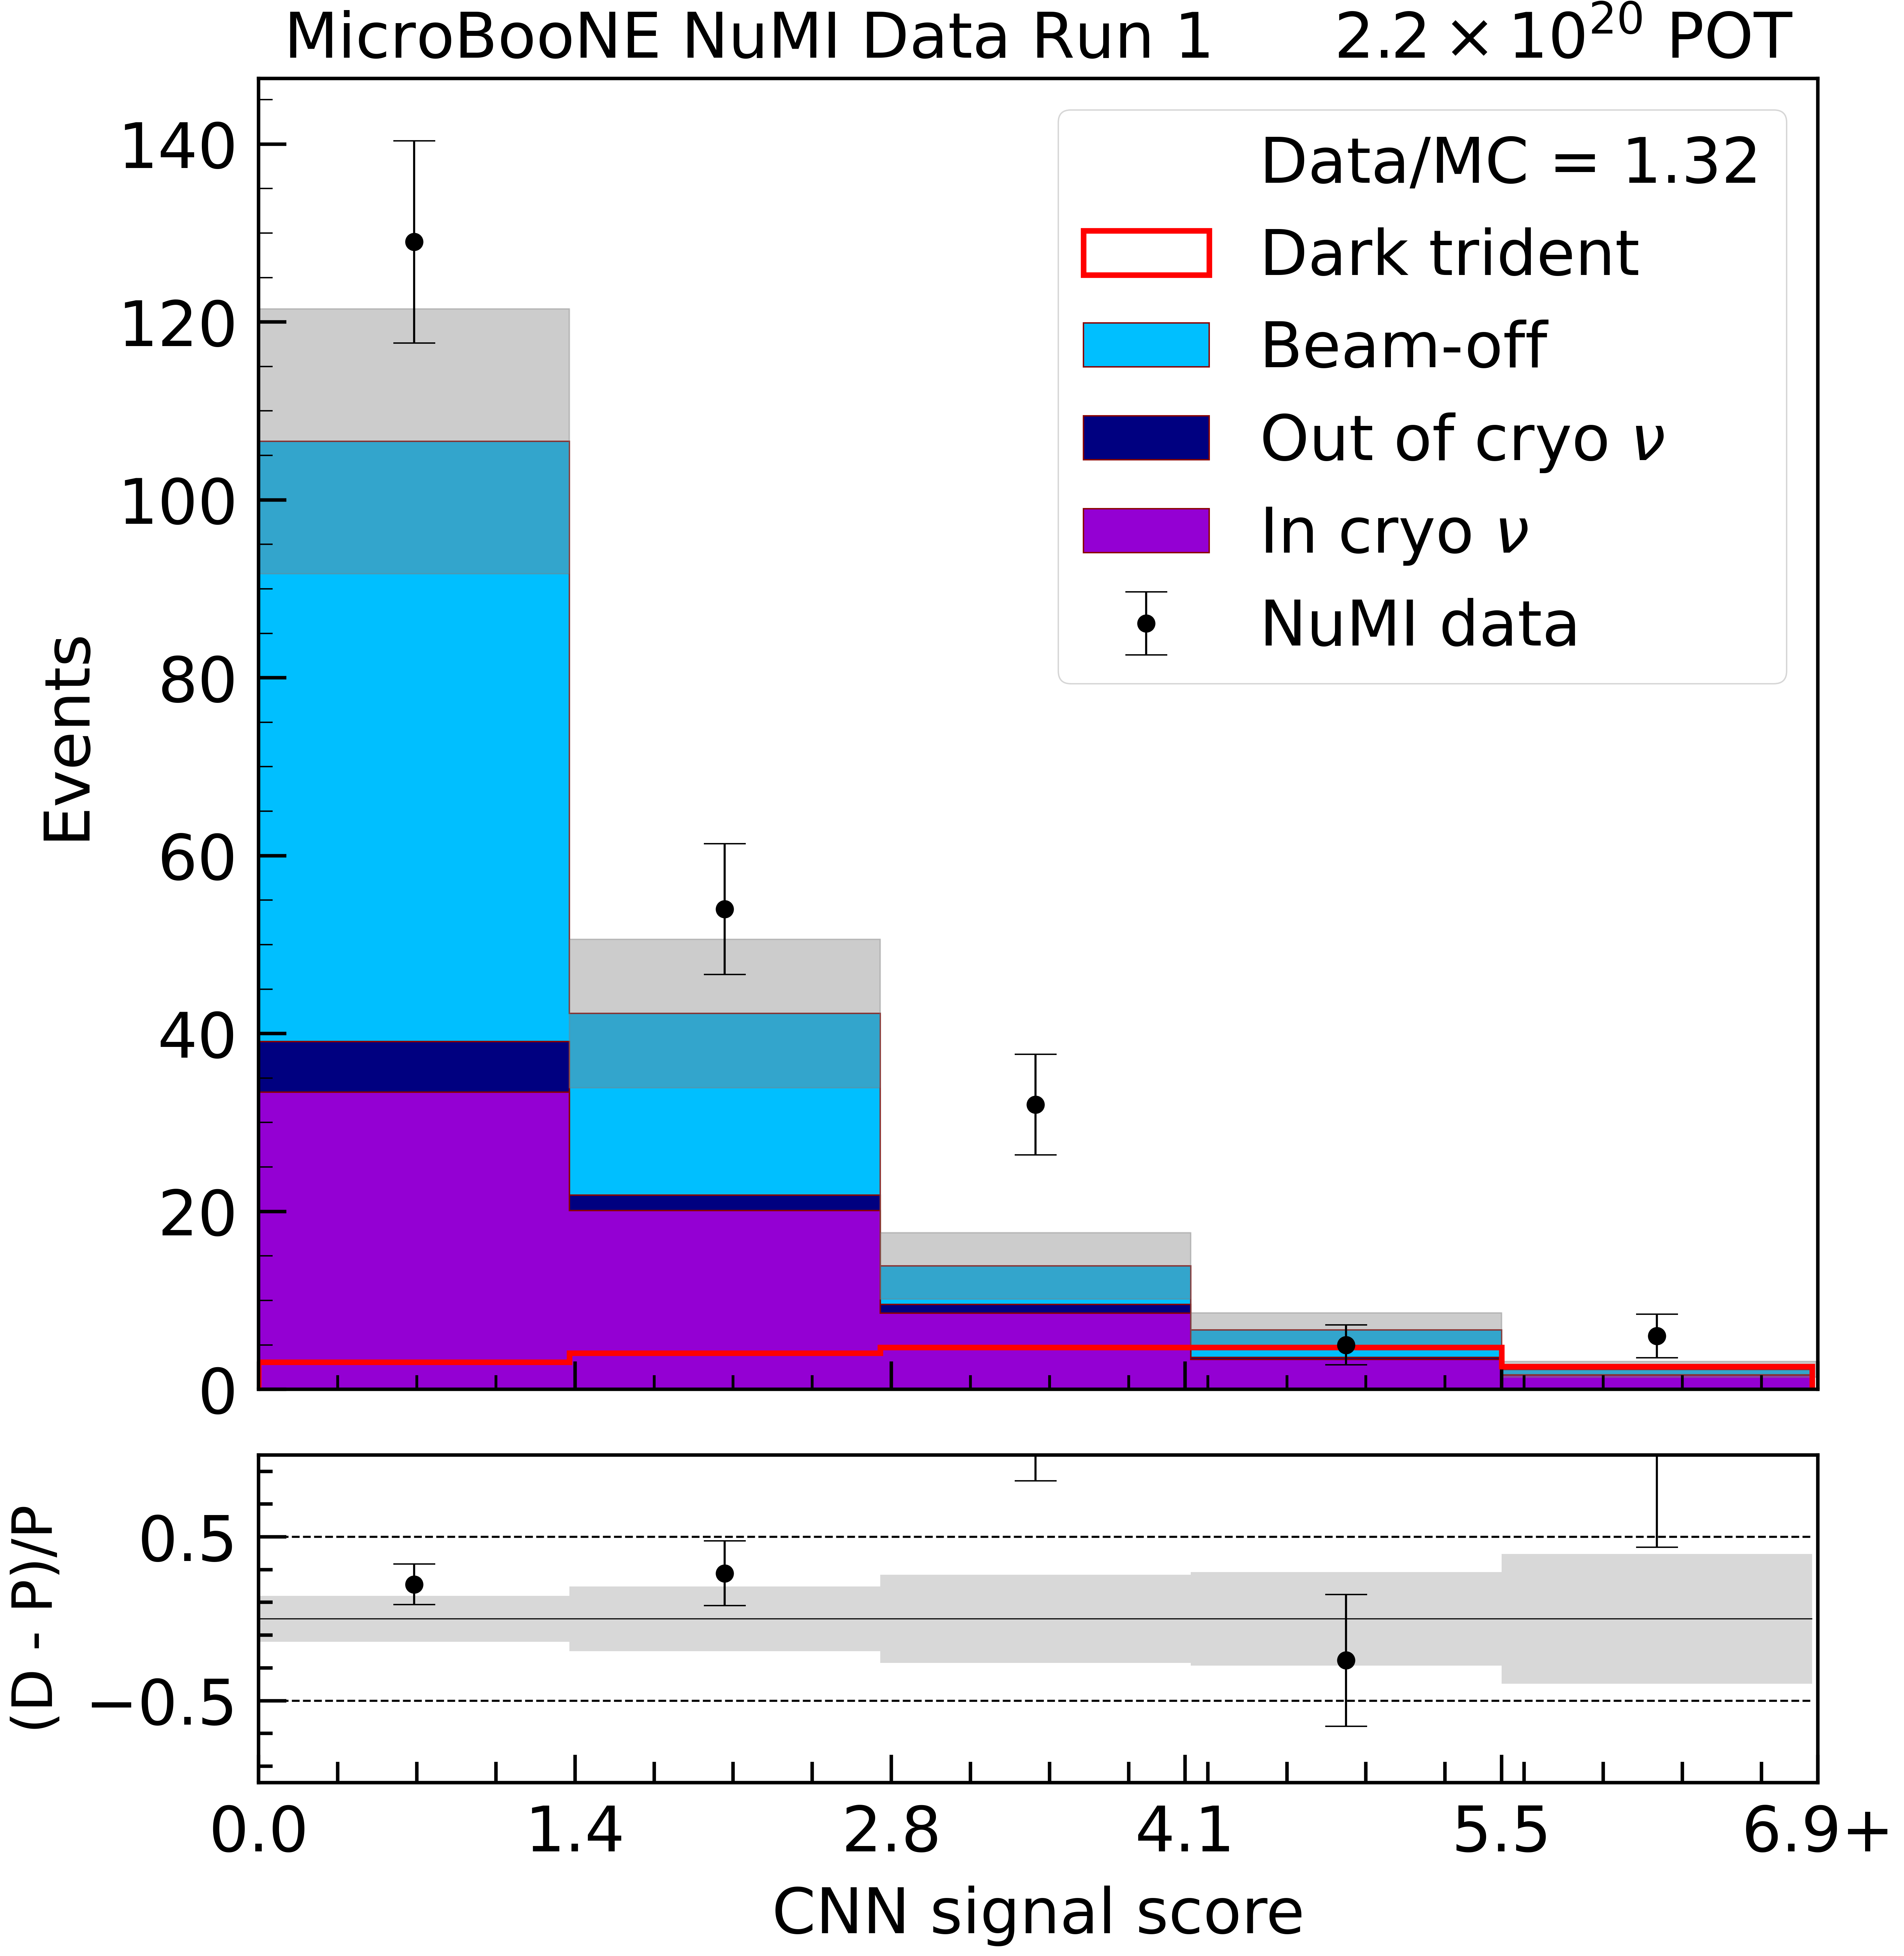

In [6]:
max_tresh = 11.

df_nu = df_nu[df_nu['signal_score'] >= 0.5]
df_dirt = df_dirt[df_dirt['signal_score'] >= 0.5]
df_offbeam = df_offbeam[df_offbeam['signal_score'] >= 0.5]
df_beamon = df_beamon[df_beamon['signal_score'] >= 0.5]


df_nu['signal_score'] = logit_transform(df_nu['signal_score'])
df_dirt['signal_score'] = logit_transform(df_dirt['signal_score'])
df_offbeam['signal_score'] = logit_transform(df_offbeam['signal_score'])
df_beamon['signal_score'] = logit_transform(df_beamon['signal_score'])


df_data_aux = df_beamon[df_beamon['signal_score'] > 5.5]

variable = 'signal_score'
up_plot = 6.875
down_plot = 0.


# Open signal histogram:

signal_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/{}_signal/".format(run)
signal_file = u.open(signal_dir + "{}_ratio_{}_signal_hist_{}_CNN.root".format(dm_type,ratio,run))
(counts_signal,bins_signal) = signal_file["signal_"+mass].to_numpy()


(counts_fake, bins_final) = np.histogram(df_nu[variable], bins = final_custom_bins)
(counts_nu, bins_nu) = np.histogram(df_nu[variable], bins = my_custom_bins, weights = df_nu['weight'])
(counts_dirt, bins_dirt) = np.histogram(df_dirt[variable], bins = my_custom_bins, weights = df_dirt['weight'])
(counts_offbeam, bins_offbeam) = np.histogram(df_offbeam[variable], bins = my_custom_bins)
(counts_beamon, bins_beamon) = np.histogram(df_beamon[variable], bins = my_custom_bins)

total_bkg_exp = np.sum(counts_nu)*nu_scaling + np.sum(counts_dirt)*dirt_scaling + np.sum(counts_offbeam)*offbeam_scaling
data_mc = np.sum(counts_beamon)/total_bkg_exp

print("Showing results for: " + run)
print("Number of dark tridents M_A="+str(mass)+" :" + str(np.sum(counts_signal)))
print("Number of neutrinos: " + str(np.sum(counts_nu)*nu_scaling))
print("Number of dirt: " + str(np.sum(counts_dirt)*dirt_scaling))
print("Number of beam-off: " + str(np.sum(counts_offbeam)*offbeam_scaling))
print("Total background: " + str(total_bkg_exp))
print("Number of beam-on: " + str(np.sum(counts_beamon)))
print("Data/MC: " + str(data_mc))




# Set plot specs with patches!!!


dt_legend = r'Dark trident'

nu_legend = r'In cryo $\nu$'
dirt_legend = r'Out of cryo $\nu$'
beamoff_legend = r'Beam-off'
beamon_legend = r'NuMI data'

stacked_colors = ["darkviolet","navy","deepskyblue"]
stacked_legend = [nu_legend, dirt_legend, beamoff_legend]
stacked_bins = [bins_final[:-1], bins_final[:-1], bins_final[:-1]]
stacked_list = [counts_nu*nu_scaling, counts_dirt*dirt_scaling, counts_offbeam*offbeam_scaling ]

stacked_signal_hist = counts_signal*signal_limit_scaling*extra_scaling 


# Getting stats error, note: GetStatsUncert gives you the sum of the weights squared on each bin 
counts_bkg = counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling
stats_nu = GetStatsUncert(df_nu, df_nu['weight']*nu_scaling,final_custom_bins,variable)
stats_dirt = GetStatsUncert(df_dirt, df_dirt['weight']*dirt_scaling,final_custom_bins,variable)
stats_beamoff = GetStatsUncert(df_offbeam, np.ones(len(df_offbeam))*offbeam_scaling,final_custom_bins,variable)
stats_total = np.sqrt(stats_nu + stats_dirt + stats_beamoff)


print("\n")
print("Showing statistical uncertainty arrays...")
print("Nu overlay: ", np.sqrt(stats_nu))
print("Dirt: ", np.sqrt(stats_dirt))
print("Beamoff: ", np.sqrt(stats_beamoff))
print("Total : ", stats_total)


# Nu uncertainties 
nu_CV = (counts_nu*nu_scaling)
dirt_CV = (counts_dirt*dirt_scaling)
sigma_detvar = nu_CV*detvars_uncertainty
sigma_multisim = nu_CV*multisim_uncertainty
sigma_mc_dirt = dirt_CV*dirt_uncertainty

# Background uncerts
sigma_nu = np.sqrt(stats_nu + sigma_detvar**2 + sigma_multisim**2)
sigma_dirt = np.sqrt(stats_dirt + sigma_mc_dirt**2)
sigma_beamoff = np.sqrt(stats_beamoff)


# Total error 
total_error_mc = np.sqrt(sigma_nu**2 + sigma_dirt**2 + sigma_beamoff**2)
stats_error = (stats_total)/(counts_bkg)
stats_up = counts_bkg + total_error_mc
stats_down = counts_bkg - total_error_mc


print("\n")
print("Showing fractional statistical errors...")
print("Nu overlay fraction: ", np.sqrt(stats_nu)/(counts_nu*nu_scaling))
print("Dirt fraction: ", np.sqrt(stats_dirt)/(counts_dirt*dirt_scaling))
print("Beamoff fraction: ", np.sqrt(stats_beamoff)/counts_offbeam*offbeam_scaling)
print("Total fraction: ", stats_error)


# Trick for right error band on histograms 
bins_err = np.copy(bins_final)
bins_err = np.append(bins_err,[bins_err[-1] + (bins_err[2] - bins_err[1])])
stats_up = np.append(stats_up,[stats_up[-1],stats_up[-1] ])
stats_down = np.append(stats_down,[stats_down[-1],stats_up[-1]])


fig, ax = plt.subplots(2,1,figsize=(20,22),dpi=300,gridspec_kw={'height_ratios': [4, 1], 'hspace': 0.08})

for axis in ['top', 'bottom', 'left', 'right']:
    ax[0].spines[axis].set_linewidth(2.5)  # change width
    ax[0].spines[axis].set_color('black')    # change color
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax[1].spines[axis].set_linewidth(2.5)  # change width
    ax[1].spines[axis].set_color('black')    # change color


ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
    
ax[0].set_title(r'MicroBooNE Simulation' + ' ' + run_flag,fontsize=45,pad=15)   

if(data):
    ax[0].plot([], [], ' ', label=f"Data/MC = {data_mc:.2f}")
    ax[0].hist(bins_final[:-1], bins = bins_final, weights = stacked_signal_hist,
           histtype='step',stacked=True, color = "red", label = dt_legend,lw=4)

ax[0].hist(stacked_bins, bins = bins_final, weights = stacked_list, histtype='stepfilled',stacked=True, color = stacked_colors, 
           edgecolor="darkred", label = stacked_legend)
ax[0].fill_between(bins_err, stats_up, stats_down,color='gray',alpha=0.4,step='post')

if(data):
    ax[0].set_title(r'MicroBooNE NuMI Data' + ' ' + run_flag + ""+ pot_label ,fontsize=45,pad=15)
    ax[0].errorbar(bins_final[:-1]+ 0.5*(bins_final[1:] - bins_final[:-1]),counts_beamon,yerr=np.sqrt(counts_beamon),fmt='o',markersize=12, capsize=15, color='black',label=beamon_legend)

if(not data):  
    ax[0].hist(bins_final[:-1], bins = bins_final,weights=counts_signal*extra_scaling, histtype='step',label=dt_legend ,fill=False, edgecolor='red', linewidth=4)
ax[0].legend(fontsize=45)
ax[0].tick_params(axis="y", which='major', direction="in",length=20,width=2.5,pad=15, labelsize=45)
ax[0].tick_params(axis="y", which='minor', direction="in",length=10,width=1.0,labelleft=False, labelsize=45)
ax[0].tick_params(axis="x", which='major', direction="in",length=20,width=2.5,pad=15, bottom=True,top=False,labelbottom=False)
ax[0].tick_params(axis="x", which='minor', direction="in",length=10,width=2.0, bottom=True,top=False,labelbottom=False)
ax[0].set_xlim(down_plot,up_plot)
ax[0].set_ylabel("Events",fontsize=45, labelpad=15) 

total_pred = (counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling )
ratio = (counts_beamon - total_pred)/(total_pred)

subs_error = np.sqrt( counts_beamon + stats_total**2)

total_error = np.abs(ratio)*np.sqrt( (subs_error/(counts_beamon - total_pred))**2 + (stats_total/total_pred)**2)


if(data):
    ax[1].errorbar(bins_final[:-1]+ 0.5*(bins_final[1:] - bins_final[:-1]),ratio,yerr=total_error,fmt='o',markersize=12,capsize=15,color='black')
ax[1].hist(bins_final[:-1], bins = bins_final,weights=total_error_mc/counts_bkg,histtype='stepfilled',color='gray',alpha=0.3,lw=2)
ax[1].hist(bins_final[:-1], bins = bins_final,weights=-1*total_error_mc/counts_bkg,histtype='stepfilled',color='gray',alpha=0.3,lw=2)
ax[1].hlines(0.,down_plot,up_plot,color='black',linewidth=0.8)
#ax[1].hlines(-0.75,down_plot,up_plot,color='black',linestyle="--",linewidth=0.8)
#ax[1].hlines(0.75,down_plot,up_plot,color='black',linestyle="--",linewidth=0.8)
ax[1].hlines(-0.5,down_plot,up_plot,color='black',linestyle="--",linewidth=1.5)
ax[1].hlines(0.5,down_plot,up_plot,color='black',linestyle="--",linewidth=1.5)
ax[1].tick_params(axis='x', which='minor',direction="in", length=15, width=2.5, labelsize=45)
ax[1].tick_params(axis='y', which='minor',direction="in", length=10, width=2.5, labelsize=45)
ax[1].tick_params(axis='x', which='major',direction="in", length=20, width=2.5, pad=15, labelsize=45)
ax[1].tick_params(axis='y', which='major',direction="in", length=20, width=2.5, pad=15, labelsize=45)
ax[1].set_yticks([-0.5,0.5])
ax[1].set_ylim(-1.,1.)
ax[1].set_xlabel(r'CNN signal score',fontsize=45,labelpad=15)
ax[1].set_xlim(down_plot,up_plot)
ax[1].set_ylabel(r'Fraction error',fontsize=40,labelpad=15)
ax[0].set_xticks(np.round(bins_final,1))
ax[1].set_xticks(np.round(bins_final,1))
ax[1].set_xticklabels(["0.0", "1.4", "2.8", "4.1", "5.5", "6.9+"])

if(data):
    ax[1].set_ylabel(r'(D - P)/P',fontsize=40,labelpad=15)
    plt.savefig(plots_dir + "data_mc_comparison_" + run + "_" + variable + "_box.pdf",bbox_inches="tight")
    plt.savefig(plots_dir + "data_mc_comparison_" + run + "_" + variable + "_box.png",bbox_inches="tight")
else:
    plt.savefig(plots_dir + "CNN_distributions_" + run + "_" + variable + "_box.pdf",bbox_inches="tight")
    plt.savefig(plots_dir + "CNN_distributions_" + run + "_" + variable + "_box.png",bbox_inches="tight")

In [7]:
# Print list of sinal-like events
for entry in range(len(df_data_aux)):
    print("Entry: ", df_data_aux['entry_number'].iloc[entry])
    

Entry:  363.0
Entry:  737.0
Entry:  1049.0
Entry:  1278.0
Entry:  2889.0
Entry:  4204.0


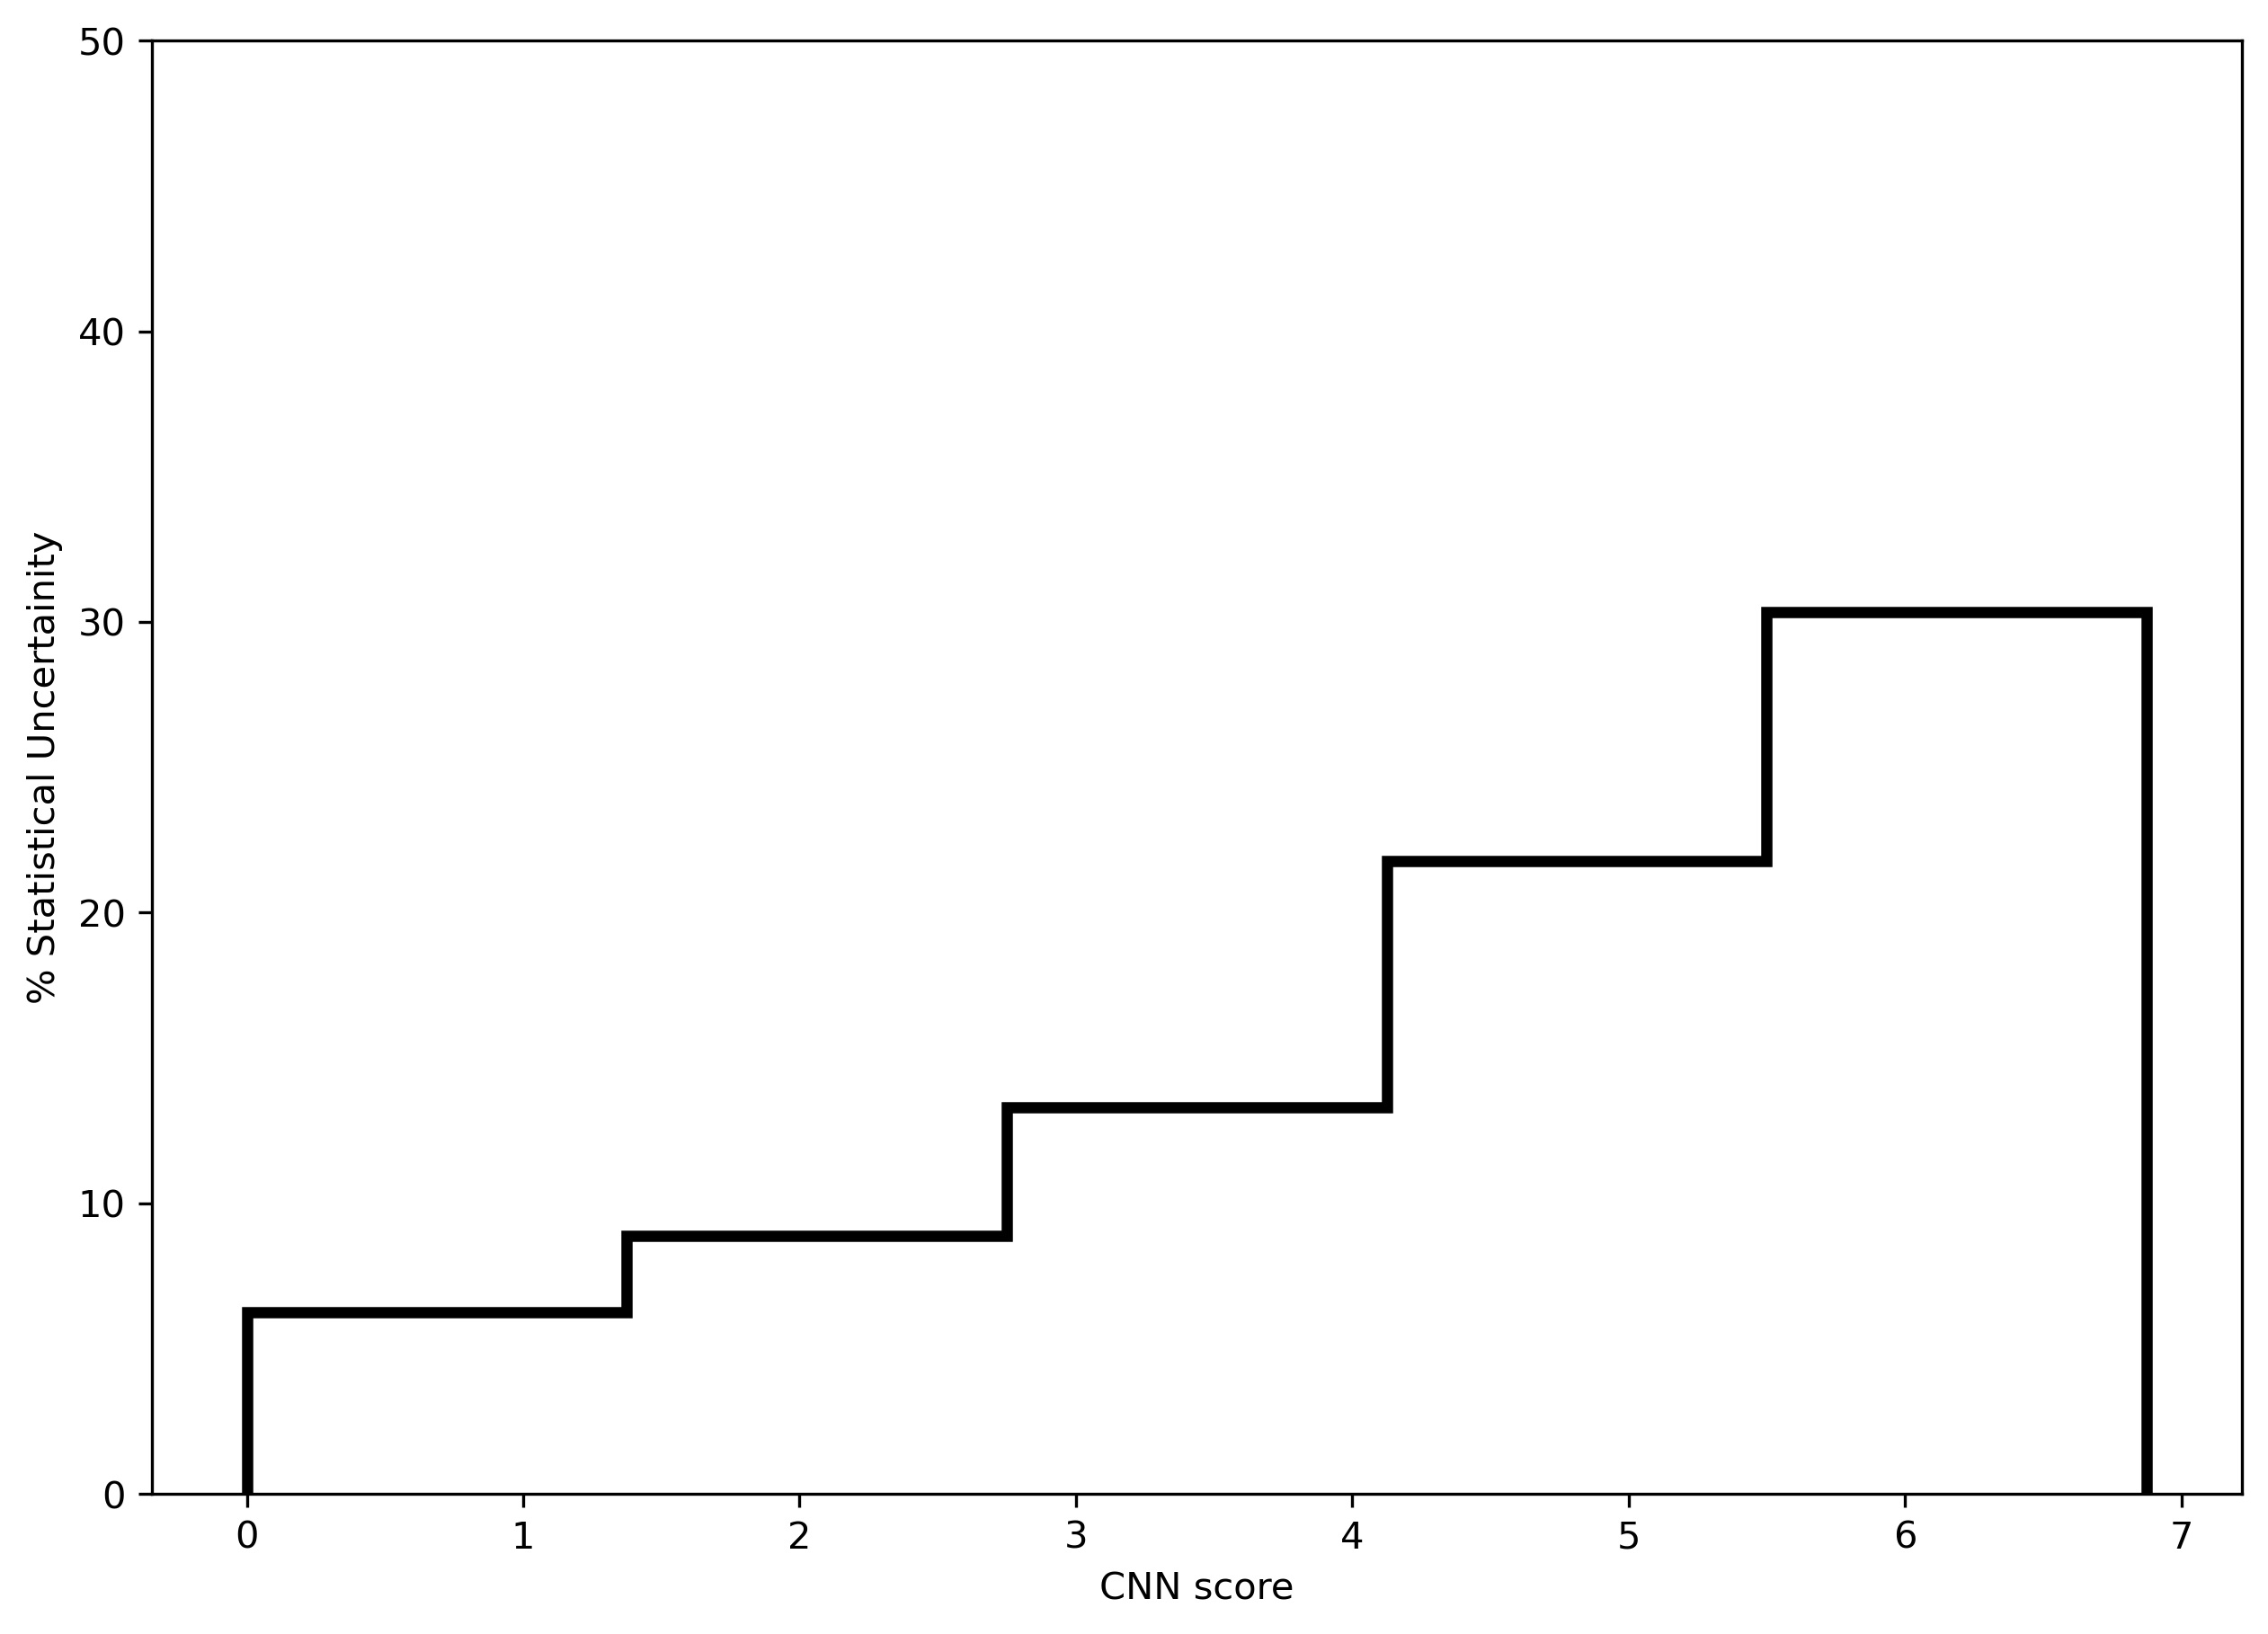

In [8]:
# Save histograms 

plt.figure(figsize=(10,7),dpi=300)
plt.hist(bins_final[:-1], bins = bins_final,weights=stats_error*100, color = "black", histtype="step",lw=3,linestyle="-")
plt.ylabel("% Statistical Uncertainity")
plt.xlabel("CNN score")
plt.ylim(0.,50)


if(create_hists):
    bkg_file = u.recreate(base_dir + "background_hist_" + run + "_CNN.root")
    bkg_file["bkg_nu_overlay"] =(counts_nu*nu_scaling, bins_nu)
    bkg_file["bkg_nu_overlay_stat_uncertainty"] = (np.sqrt(stats_nu),bins_nu)
    bkg_file["bkg_nu_overlay_stat_uncertainty_frac"] = (np.sqrt(stats_nu)/nu_CV,bins_nu)
    bkg_file["bkg_nu_DetVar_uncertainty"] = (nu_CV*detvars_uncertainty, bins_nu)
    bkg_file["bkg_nu_DetVar_uncertainty_frac"] = (nu_CV*detvars_uncertainty/nu_CV, bins_nu)
    bkg_file["bkg_dirt"] = (counts_dirt*dirt_scaling, bins_dirt)
    bkg_file["bkg_dirt_stat_uncertainty"] = (np.sqrt(stats_dirt),bins_dirt)
    bkg_file["bkg_dirt_stat_uncertainty_frac"] = (np.sqrt(stats_dirt)/(counts_dirt*nu_scaling),bins_dirt)
    bkg_file["bkg_EXT"] = (counts_offbeam*offbeam_scaling, bins_offbeam)
    bkg_file["bkg_EXT_stat_uncertainty"] = (np.sqrt(stats_beamoff),bins_offbeam)
    bkg_file["bkg_EXT_stat_uncertainty_frac"] = (np.sqrt(stats_beamoff)/(counts_offbeam*offbeam_scaling),bins_offbeam)
    bkg_file["bkg_total_hist"] = (counts_bkg, bins_final)
    bkg_file["data_hist"] = (counts_beamon, bins_final)
    bkg_file["bkg_total_uncert"] = (total_error_mc, bins_final)